# Ireland’s COVID-19 Data

## Question 1

## Setup or Importing required libraries

In [15]:
import pandas as pd     
import numpy as np
import matplotlib.pyplot as plt 
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## Loading the data

In [16]:
df = pd.read_csv(r'COVID-19_HPSC_Detailed_Statistics_Profile-01-23.csv') # Read in csv file to dataframe in Pandas
df

,X,Y,Date,ConfirmedCovidCases,TotalConfirmedCovidCases,ConfirmedCovidDeaths,TotalCovidDeaths,StatisticsProfileDate,CovidCasesConfirmed,HospitalisedCovidCases,...,FID,HospitalisedAged65to74,HospitalisedAged75to84,HospitalisedAged85up,Aged65to74,Aged75to84,Aged85up,DeathsCumulative_DOD,DeathsToday_DOD,SevenDayAvg_Cases
0,-7.692596,53.288234,2020/02/29 00:00:00+00,1,1,0.0,0,2020/02/27 00:00:00+00,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,-7.692596,53.288234,2020/03/02 00:00:00+00,0,1,0.0,0,2020/03/01 00:00:00+00,NaN,NaN,...,2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0
2,-7.692596,53.288234,2020/03/03 00:00:00+00,1,2,0.0,0,2020/03/02 00:00:00+00,1.0,0.0,...,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,-7.692596,53.288234,2020/03/04 00:00:00+00,4,6,0.0,0,2020/03/03 00:00:00+00,2.0,1.0,...,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,-7.692596,53.288234,2020/03/05 00:00:00+00,7,13,0.0,0,2020/03/04 00:00:00+00,5.0,4.0,...,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,-7.692596,53.288234,2023/01/20 00:00:00+00,117,1699796,NaN,8431,2023/01/19 00:00:00+00,1699794.0,56240.0,...,1056,9266.0,12347.0,8290.0,83420.0,47763.0,26251.0,8422.0,2.0,160
1056,-7.692596,53.288234,2023/01/21 00:00:00+00,147,1699943,NaN,8431,2023/01/20 00:00:00+00,1699941.0,56278.0,...,1057,9271.0,12361.0,8298.0,83433.0,47792.0,26278.0,8422.0,0.0,149
1057,-7.692596,53.288234,2023/01/22 00:00:00+00,29,1699972,NaN,8431,2023/01/21 00:00:00+00,1699970.0,56280.0,...,1058,9271.0,12362.0,8298.0,83435.0,47793.0,26278.0,8423.0,1.0,145
1058,-7.692596,53.288234,2023/01/23 00:00:00+00,15,1699987,NaN,8431,2023/01/22 00:00:00+00,1699985.0,56282.0,...,1059,9273.0,12362.0,8298.0,83438.0,47795.0,26278.0,8423.0,0.0,143


## Interpretation of dataset taking the features into consideration, in particular

We are suppose to do story building from this data. Before doing any statistical analysis, it is necessary to understand the data thoroughly and use some brainstorming to get an idea about what we expect as our result. For which, the datasource [1] and [2] were studied to an extent. Following are the key observations.

1) The features 'ConfirmedCovidCases' and 'ConfirmedCovidDeaths' are the daily case and death counts respectively. The 'TotalConfirmedCovidCases' is the cumulative of 'ConfirmedCovidCases' and 'TotalCovidDeaths' is the cumulative of 'ConfirmedCovidDeaths'.
2) The timestamp at which the data is tabulated is given in 'Date' column.
3) As it is Covid data, which is related to hospital, we have a feature 'HospitalisedCovidCases' in the data file. The breakdown by age groups are also included. It is understood that the age plays a crucial role in this use case and hence these features would probably contribute in the further analysis.
4) The Geographical Coordinates are entered with coordinates ('X','Y') which indicates different regions or counties within Ireland. [Though the [1] & [2] were refered, couldn't gather much information regarding these].
5) Some specific age groups like 'SevenDayAvg_Cases' is also available in the data.
6) The ConfirmedCovidDeaths are missing for latest time period after around 400 days. However, there is no missing values in TotalCovidDeaths column.

## Data Cleaning and Preprocessing (EDA)

In [17]:
columns_to_drop = ['X', 'Y', 'StatisticsProfileDate', 'FID','CommunityTransmission','CloseContact','TravelAbroad','StatisticsProfileDate'] # Drop unnecessary columns for analysis 
df_cleaned = df.drop(columns=columns_to_drop)

missing_values_summary = df_cleaned.isnull().sum() # Handle missing values

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], errors='coerce', utc=True) # Convert date columns to datetime format

data_types = df_cleaned.dtypes  # data types for verification
missing_values_summary, data_types # missing values summary

(Date                             0
 ConfirmedCovidCases              0
 TotalConfirmedCovidCases         0
 ConfirmedCovidDeaths           453
 TotalCovidDeaths                 0
 CovidCasesConfirmed              2
 HospitalisedCovidCases           2
 RequiringICUCovidCases           2
 HealthcareWorkersCovidCases      2
 ClustersNotified                23
 HospitalisedAged5                2
 HospitalisedAged5to14            2
 HospitalisedAged15to24           2
 HospitalisedAged25to34           2
 HospitalisedAged35to44           2
 HospitalisedAged45to54           2
 HospitalisedAged55to64           2
 Male                             2
 Female                           2
 Unknown                          2
 Aged1to4                         2
 Aged5to14                        2
 Aged15to24                       2
 Aged25to34                       2
 Aged35to44                       2
 Aged45to54                       2
 Aged55to64                       2
 Median_Age                 

## Handling missing values as part of EDA

In [18]:
df_cleaned['ConfirmedCovidDeaths'].fillna(0, inplace=True) # Fill missing values in 'ConfirmedCovidDeaths' with 0 (Assuming missing data could imply non-occurrence)

float_columns = df_cleaned.select_dtypes(include=['float64']).columns #Fill missing values in other float columns with 0 (Assuming missing data could imply non-occurrence or non-reporting for that day)
df_cleaned[float_columns] = df_cleaned[float_columns].fillna(0)

In [19]:
# Generate a statistical summary of the dataset for key columns
statistical_summary = df_cleaned[['ConfirmedCovidCases', 'TotalConfirmedCovidCases', 'ConfirmedCovidDeaths', 'TotalCovidDeaths', 'HospitalisedCovidCases']].describe()

statistical_summary

,ConfirmedCovidCases,TotalConfirmedCovidCases,ConfirmedCovidDeaths,TotalCovidDeaths,HospitalisedCovidCases
count,1060.000000,1.060000e+03,1060.000000,1060.000000,1060.000000
mean,1594.716038,6.859008e+05,7.990566,4815.893396,21600.240566
std,3026.046481,6.725911e+05,15.605255,2489.317258,17138.211016
min,0.000000,1.000000e+00,0.000000,0.000000,0.000000
25%,265.750000,7.005775e+04,0.000000,2021.000000,5150.750000
50%,531.000000,3.199260e+05,0.000000,5059.000000,15764.000000
75%,1527.750000,1.520614e+06,9.000000,7104.250000,37738.750000
max,26122.000000,1.700253e+06,101.000000,8462.000000,56357.000000


## A statistical summary for key columns 
1) Only the above features were considered to do a preliminary statistical summary. The selection of these features was done after brainstorming.
2) The mean of Daily confirmed Covid Cases average to 1595 cases (Rounding off decimal to higher value as it indicates population). Also, the standard deviation is found to be 3026 which indicates there is a significant variation in the daily case numbers.
3)The Total Confirmed Covid Cases show a steady increase. [This is as expected in accordance with the problem scenario]. 
4) Also, there is a variance in the Daily Confirmed Covid Deaths with the highest value as 101 and on an average, there were eight death per day. For couple of days, zero death were reported.
5) Regarding the Total Covid Deaths, the maximum value is 8462 with mean around 4816 which implies how bad the situation was during Covid 19 pandemic.
6) As mentioned earlier, the hopsital scenario is crucial in this case. As expected, there is a fluctuation or variation in the hospitalisation rates which will have to be analysed going further.

## Use visualisation to give a better picture

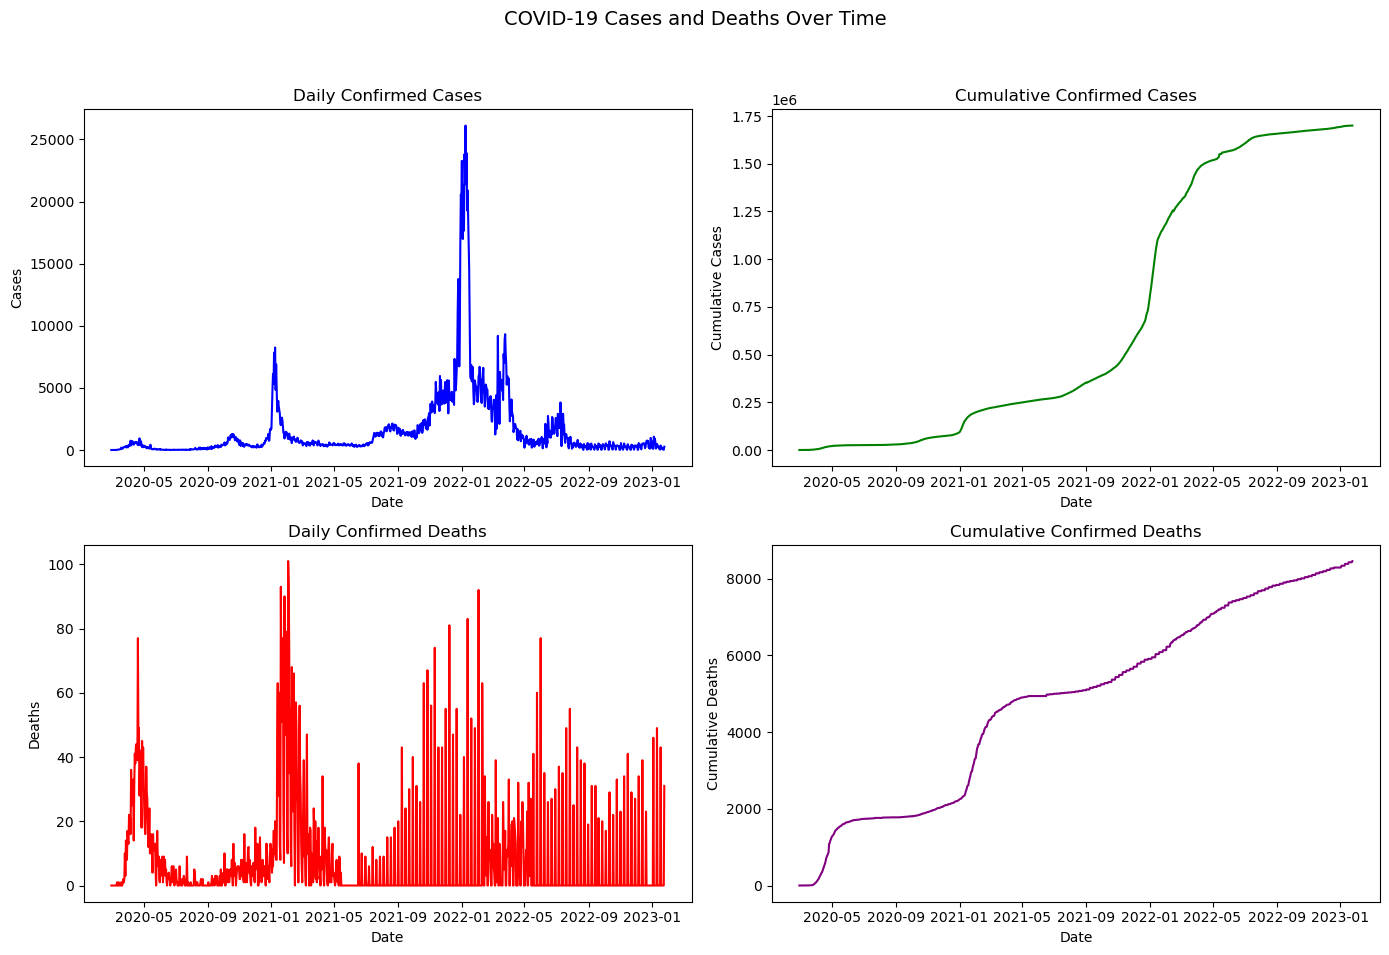

In [20]:
# Create time series plots for daily and cumulative confirmed cases and deaths
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('COVID-19 Cases and Deaths Over Time', fontsize=14)

# Daily Confirmed Cases
sns.lineplot(ax=axes[0, 0], x='Date', y='ConfirmedCovidCases', data=df_cleaned, color='blue')
axes[0, 0].set_title('Daily Confirmed Cases')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Cases')

# Cumulative Confirmed Cases
sns.lineplot(ax=axes[0, 1], x='Date', y='TotalConfirmedCovidCases', data=df_cleaned, color='green')
axes[0, 1].set_title('Cumulative Confirmed Cases')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Cumulative Cases')

# Daily Confirmed Deaths
sns.lineplot(ax=axes[1, 0], x='Date', y='ConfirmedCovidDeaths', data=df_cleaned, color='red')
axes[1, 0].set_title('Daily Confirmed Deaths')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Deaths')

# Cumulative Confirmed Deaths
sns.lineplot(ax=axes[1, 1], x='Date', y='TotalCovidDeaths', data=df_cleaned, color='purple')
axes[1, 1].set_title('Cumulative Confirmed Deaths')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Cumulative Deaths')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


## Interpretation of above graphs

1) As we can see from the graph, the daily confirmed cases and death fluctuates over time. 
2) The cumulative confirmed cases and death increases over time as per the graph. It shows a steady increase. The rate at which the pandemic spread  can be understood by observing the slope.

## Model building (Linear Regression)

In [21]:
# Prepare the data for modeling
X = df_cleaned[['ConfirmedCovidCases']]
y = df_cleaned['ConfirmedCovidDeaths']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
MSE = mean_squared_error(y_test, y_pred)
R_Squared = r2_score(y_test, y_pred)

# Coefficients
coefficients = model.coef_
intercept = model.intercept_

MSE, R_Squared, coefficients, intercept

(258.67559962362054,
 -0.003454645782875021,
 array([0.00020037]),
 7.42145881897618)

## Interpretation (Linear Regression)
1) The R-Squared value is -0.00345. The R-Squared value indicates how much variation of 'ConfirmedCovidDeaths' is explainable by 'ConfirmedCovidCases'. Here, the value is close to zero and is negative. Hence, it can be concluded that the model is not able to explain the death counts given the ConfirmedCovidCases. 
2) Mean Square Error is found to be 258.675
2) Hence, we would not be looking at other parameters we got as output here. Instead, we will try other algorithms to train the model.

## Model building  (Polynomial Regression)

In [22]:
# Importing other necessary libraries.
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Introduce a time lag of 14 days for confirmed cases
df_cleaned['ConfirmedCovidCases_lag14'] = df_cleaned['ConfirmedCovidCases'].shift(14).fillna(0)

# Update our X to include the lagged variable
X_lag = df_cleaned[['ConfirmedCovidCases_lag14']]
y_lag = df_cleaned['ConfirmedCovidDeaths']

# Split the data with lagged feature into training and testing sets
X_lag_train, X_lag_test, y_lag_train, y_lag_test = train_test_split(X_lag, y_lag, test_size=0.2, random_state=42)

# Explore a more complex model: Polynomial Regression
# We choose a degree of 2 for polynomial features to capture potential non-linear relationships
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Fit the model
poly_model.fit(X_lag_train, y_lag_train)

# Predict on the testing set
y_lag_pred = poly_model.predict(X_lag_test)

# Evaluate the model with lagged feature
mse_lag = mean_squared_error(y_lag_test, y_lag_pred)
r2_lag = r2_score(y_lag_test, y_lag_pred)

mse_lag, r2_lag


(242.4793109011021, 0.05937401369138284)

## Interpretation (Polynomial Regression)
1) The MSE reduced to 242.479 compared to 258.68 from the linear regression model without a lag. Lower MSE indicates, better fit to the model to the data. It can be concluded that the time lag and introducing polynomial features has enhanced the model performance.
2) R-Sqaured is positive but still low. The increase in R-Sqaured value suggests the model is better compared to the first model. However, still the R-Sqaured value is low and further improvements need to be done to capture more information from data and to build a better model.

Note: The time-lag captured the delayed effect of confirmed cases on deaths. The assumption here is that if a death is happening today, the said case may have been confirmed several days before. On a standard basis, we have taken time lag as 2 weeks.

## Model building (Random Forest)

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Split the data with lagged feature into training and testing sets again
X_lag_train, X_lag_test, y_lag_train, y_lag_test = train_test_split(X_lag, y_lag, test_size=0.2, random_state=42)

# Initialize and train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_lag_train, y_lag_train)

# Predict on the testing set
y_rf_pred = rf_model.predict(X_lag_test)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_lag_test, y_rf_pred)
r2_rf = r2_score(y_lag_test, y_rf_pred)

# Initialize and train a Gradient Boosting Regressor
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbm_model.fit(X_lag_train, y_lag_train)

# Predict on the testing set
y_gbm_pred = gbm_model.predict(X_lag_test)

# Evaluate the Gradient Boosting model
mse_gbm = mean_squared_error(y_lag_test, y_gbm_pred)
r2_gbm = r2_score(y_lag_test, y_gbm_pred)

mse_rf, r2_rf, mse_gbm, r2_gbm


(323.34008739199237,
 -0.2543011916602447,
 260.118947056252,
 -0.009053680592730373)

## Interpretation (Random Forest)
1) R-Squared value is negative which indicates the model is not good. Also, the MSE value is high compared to the performance in above models.
2) Hence, Random Forest and Gradient Boosting Model does not perform well on the given dataset.

### 7-Day Rolling Average
1) A statistical technique used to analyze time-series data by calculating the average of a dataset over 7-day periods. 
2) Commonly applied to smooth out short-term fluctuations and highlight longer-term trends or cycles in the data.
3) Reduces noise in data.

## Model building (XGBoost algorithm)

In [24]:
# Calculate 7-day rolling averages for 'ConfirmedCovidCases' and 'ConfirmedCovidDeaths'
df_cleaned['Cases_7day_RA'] = df_cleaned['ConfirmedCovidCases'].rolling(window=7).mean().shift(1)  
df_cleaned['Deaths_7day_RA'] = df_cleaned['ConfirmedCovidDeaths'].rolling(window=7).mean()

# Display the updated dataframe with the 7-day rolling averages included
df_cleaned[['ConfirmedCovidCases', 'Cases_7day_RA', 'ConfirmedCovidDeaths', 'Deaths_7day_RA']].head()

# Drop rows with NaN values resulting from rolling average calculation
df_cleaned.dropna(inplace=True)

# Update features to include the 7-day rolling average of cases
X_ra = df_cleaned[['Cases_7day_RA']]
y_ra = df_cleaned['Deaths_7day_RA']

# Split data into training and testing sets for the rolling average model
X_ra_train, X_ra_test, y_ra_train, y_ra_test = train_test_split(X_ra, y_ra, test_size=0.2, random_state=42)

# Train the XGBoost model with the rolling average features
model_xgb_ra = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb_ra.fit(X_ra_train, y_ra_train)

# Predict on the testing set with rolling average features
y_ra_pred_xgb = model_xgb_ra.predict(X_ra_test)

# Calculate MSE for the predictions with rolling average
mse_xgb_ra = mean_squared_error(y_ra_test, y_ra_pred_xgb)

mse_xgb_ra

134.11278397382563

## Interpretation (XGBoost model)
1) The MSE value is less compared to above models. Hence, the model is better than above.
2) We simplify the model now inorder to reduce the execution time and will mention the interpretation of XGboost in detail.

## Simplified XGBoost (Simplified model)

In [25]:
# Simplify the model to ensure it completes within the execution time limit
model_xgb_simple = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, random_state=42)
model_xgb_simple.fit(X_ra_train, y_ra_train)

# Predict on the testing set with rolling average features
y_ra_pred_xgb_simple = model_xgb_simple.predict(X_ra_test)

# Calculate MSE for the predictions with rolling average, using the simplified model
mse_xgb_ra_simple = mean_squared_error(y_ra_test, y_ra_pred_xgb_simple)

mse_xgb_ra_simple


131.4111968443239

## Interpretation (Simplified XGBoost model):
1) We used a simpifiled XGBoost model with50 estimators and a learning rate of 0.1. It was trained on features including a 7-day rolling average of confirmed COVID-19 cases. 
2) We achieved a Mean Squared Error (MSE) of approximately 131.411 on the test set. Lower the MSE value indicates, the model perform better than other models above.
3) Hence, simplified XGBoost with feature engineering (through rolling average) is capable of capturing complex patterns in the data given.

## ARIMA: (As the data is time series, it could be worth trying the same.)

1) Null hypothesis: The time series is non-stationarity 
2) Alternate hypothesis: The time series is stationarity.

In [26]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Test for stationarity of the 'ConfirmedCovidDeaths' time series
result = adfuller(df_cleaned['ConfirmedCovidDeaths'].dropna())

# Display the ADF test results
adf_statistic, p_value = result[0], result[1]

adf_statistic, p_value

(-4.055531879307724, 0.001146077547310143)

## Interpretation(ARIMA)

1) We can see that the p-value < 0.05, and hence the null hypothesis can be rejected. 

## Model building (ARIMA)

In [27]:
# Fit an ARIMA(1,0,1) model to the 'ConfirmedCovidDeaths' data
model = ARIMA(df_cleaned['ConfirmedCovidDeaths'], order=(1,0,1))
model_fit = model.fit()

# Summary of the model
model_summary = model_fit.summary()

model_summary

D:\UCC\SOFTWARES\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\UCC\SOFTWARES\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\UCC\SOFTWARES\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     ConfirmedCovidDeaths   No. Observations:                 1053
Model:                   ARIMA(1, 0, 1)   Log Likelihood               -4223.888
Date:                  Mon, 19 Feb 2024   AIC                           8455.777
Time:                          11:53:39   BIC                           8475.614
Sample:                               0   HQIC                          8463.297
                                 - 1053                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7425      5.267      1.470      0.142      -2.581      18.066
ar.L1          0.9821      0.006    163.444      0.000       0.970       0.994
ma.L1         -0.8696      0.015    -57.868      0.000      -0.899      -0.840
sigma2       178.3618      5.366     33.239      0.000     167.845     188.879
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              4847.79
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             2.54
Prob(H) (two-sided):                  0.08   Kurtosis:                        12.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Interpretation (ARIMA)
1) AIC and BIC values are 8505.059 and 8524.923 respectively. Lower the values, better the model.
2) The variane of model error is 177.213.
3) The ARIMA model could capture some of the information of the Covid-19 data, as we can interpret from its components (AR & MA). 
4) However, the Skewness and Kurtosis is high.

## Question 2 (a)

Our model building objective was to predict death based on the confirmed cases. The effect of testing rate was not considered. Hence, inorder to explain the diagnosed cases, we need to consider models that estimates true infection rates based on reported cases taking into consideration of test positivity rates and the rate of infection, to name a few.

## Question 2 (b)

The vaccine data was not available and accordingly the vaccination rates is a constarin for answering this question. Also, the Omicron variant, eficacy against those variant etc. need to be considered. Hypothetically we can say that if the vaccine had been ineffective, the number of deaths would have increased. [How many people out of 100 (say) got vaccinated is becoming Covid positive again?, How many of these people died?, etc. need to be considered for this]

## Question 4: Report Summary

a) This report presents an analysis of COVID-19 case and death data inorder to answer the specific hypothetical questions about testing and vaccine efficacy. As you can see from the analysis, we tried several statistical  machine learning models, including linear regression, Polynomial Regression, Random Forest, ARIMA, and XGBoost to predict COVID-19-related deaths from confirmed cases. Our analysis aimed to identify the model that best captures the complex relationships in the data. 

b) We used data manipulation techniques, including the calculation of time lags and use of rolling averages into our predictive models. Time lags helped to capture the delayed effects of confirmed cases on deaths, while rolling averages smoothed short-term fluctuations, revealing underlying trends.

c) We used linear regression, polynomial regression, ARIMA, XGBoost and Random Forest models. These models were chosen on the need to accommodate the nonlinear and temporal nature of the data. Model performance was evaluated using metrics such as MSE and R-squared, with ARIMA showing potential for capturing complex patterns. The XGBoost shows potential for capturing complex patterns through temporal feature engineering (rolling average).

d) The incorporation of additional variables like testing rates, vaccination data in more models like ARIMAX could answer hypothetical questions about testing and vaccine efficacy.Also, we used 7-Day Rolling average to approach a conclusion. It calculates the average of dataset over 7-day period.

e) Our model evaluation focused on MSE and R-squared values to assess model fit and predictive accuracy. While linear and polynomial regression models provided baseline performance, the ARIMA model captured temporal dependencies, and XGBoost, with feature engineering, offered a promising approach for handling the data's complexity.

f) The analysis actually highlights the challenges of modeling Covid 19 dynamics and the potential of combining machine learning with temporal feature engineering to improve predictions. We need more comprehensive data, including testing rates and vaccination efficacy, to enhance model accuracy and relevance to decison-making.

## Further Scope (Other ideas)
1) Doing data partition based on time could be done to do the analysis to grab the relationship. This will tell how number of deaths is related to vaccination and retest. 


    a) Low testing but more Covid deaths.
    
    b) High testing and more Covid deaths




2) The total covid death could have been used to fill in missing values in confirmed covid death.

## Limitations
1) The vaccination details were not available in the data used for analysis.
2) The difference between columns 'ConfirmedCovidCases' and'CovidCasesConfirmed' was not clear.
3) The exact geographical location were not mentioned.
4) More details including Blood group, BMI, past disease details, other existing disease details could have been mentioned.

## Notes

The analysis was done in context to answer the questions in the relevant PDF file as part of EE6024 assignment. Some other analysis might be possible from given data for any relevant problem statement. Some problems that I could understand which can be adressed from the data is as follows:
1) How to prioritise HospitaisedCovidCases with RequiringICUCases?
2) Analysis considering age groups? Or say, for children and 60+ people.
3) Analysis could be done for different geographical locations?
4) Analysis considering Male Female ratio.

# References
1) Ireland's Covid 19 Data website (https://covid-19.geohive.ie/)
2) Website of Central Statistics Office, Ireland (https://www.cso.ie/)
3) United Nations website (https://www.un.org/)
4) https://docs.python.org/
5) https://pandas.pydata.org/pandas-docs/
6) https://matplotlib.org/stable/tutorials/
7) https://numpy.org/
8) https://stackoverflow.com/